In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dostop do datoteke
file_path = 'PrometneNesreče.csv'
data = pd.read_csv(file_path)

C:\Users\Hana\AppData\Local\Temp\ipykernel_42608\3269022550.py:3: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


# Število nesreč po letih

In [6]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

# Za vsak vnos pridobi, katero leto je blo
years = data['NastanekDatumCas'].dt.year

# Preštej število nesreč za vsak mesec
accidents_per_year = years.value_counts().sort_index()

# print(accidents_per_year)

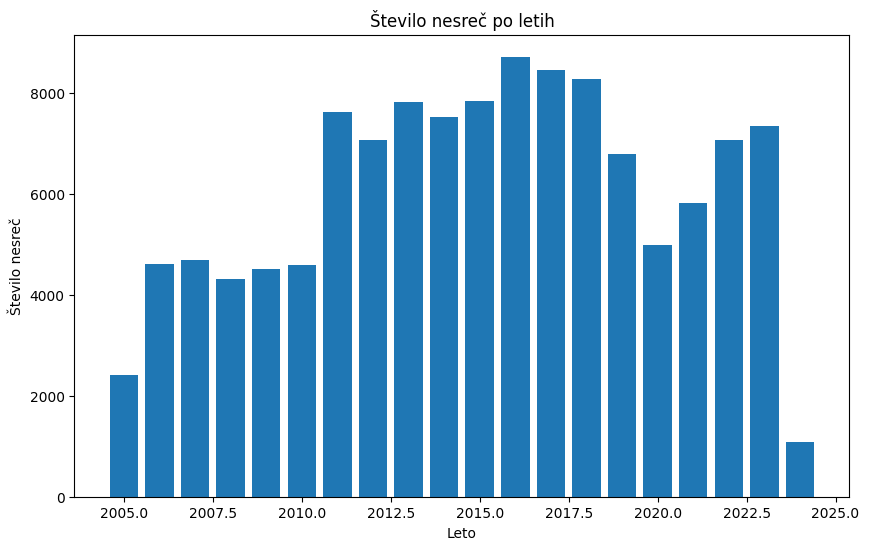

In [7]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(accidents_per_year.index, accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč po letih')

plt.show()

# **Resnost posledic prometnih nesreč**

Tri kategorije nesreč:
- **Nesreče brez poškodovancev**: udeleženci niso bili poškodovani in nihče ni umrl
- **Nesreče s poškodbami**: nekateri udeleženci so bili poškodovani, vendar nihče ni umrl
- **Nesreče s smrtnim izidom**: vsaj eden od udeležencev je umrl (v nesreči so bili lahko tudi drugi, ki so bili poškodovani, vendar take nesreče ne štejem v kategorijo "Nesreče s poškodbami")

## Nesreče brez poškodovancev

In [8]:
# Nesreče brez poškodovancev in smrtnih žrtev
mild_accidents_entries = data[(data['LjudjeMrtvi'] == 0) & (data['LjudjePoskodovani'] == 0)]

# Za vsak vnos pridobi mesec nesreče
mild_years = mild_accidents_entries['NastanekDatumCas'].dt.year

mild_accidents_per_year = mild_years.value_counts().sort_index()

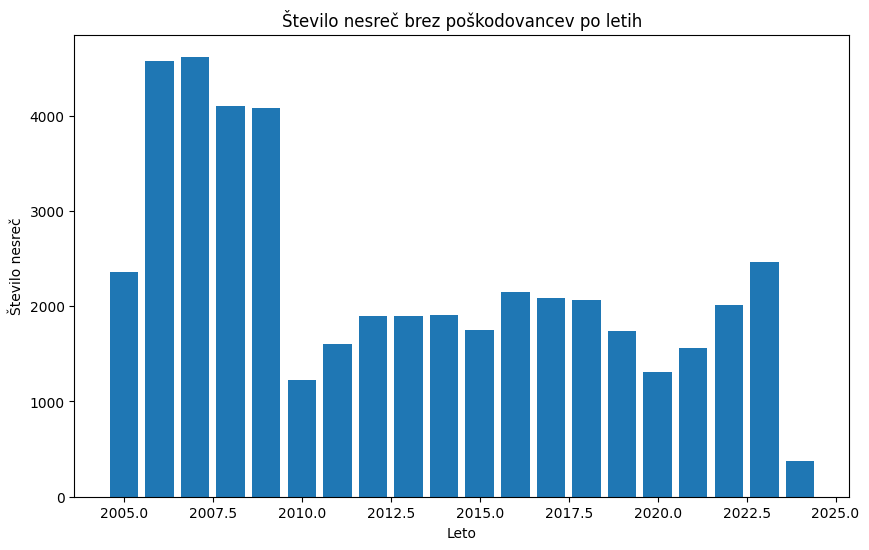

In [9]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(mild_accidents_per_year.index, mild_accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč brez poškodovancev po letih')

plt.show()

## Nesreče s poškodbami

In [10]:
# Nesreče s poškodbami
injury_accidents_entries = data[(data['LjudjeMrtvi'] == 0) & (data['LjudjePoskodovani'] != 0)]

# Za vsak vnos pridobi mesec nesreče
injury_years = injury_accidents_entries['NastanekDatumCas'].dt.year

injury_accidents_per_year = injury_years.value_counts().sort_index()

Text(0.5, 1.0, 'Število nesreč s poškodbami po letih')

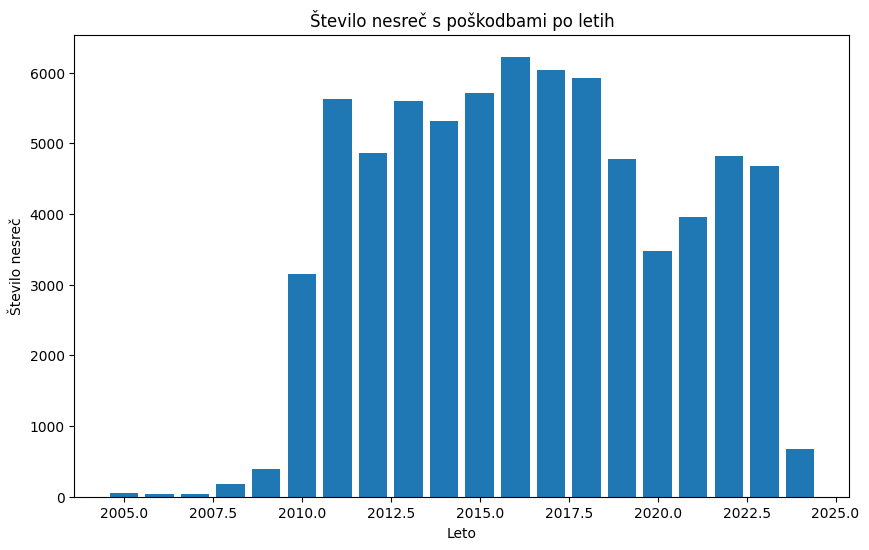

In [11]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(injury_accidents_per_year.index, injury_accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč s poškodbami po letih')

## Nesreče s smrtnim izidom

In [12]:
# Nesreče s smrtnimi žrtvami
death_accidents_entries = data[(data['LjudjeMrtvi'] != 0)]

# Za vsak vnos pridobi mesec nesreče
death_years = death_accidents_entries['NastanekDatumCas'].dt.year

death_accidents_per_year = death_years.value_counts().sort_index()

Text(0.5, 1.0, 'Število nesreč s smrtnimi žrtvami po letih')

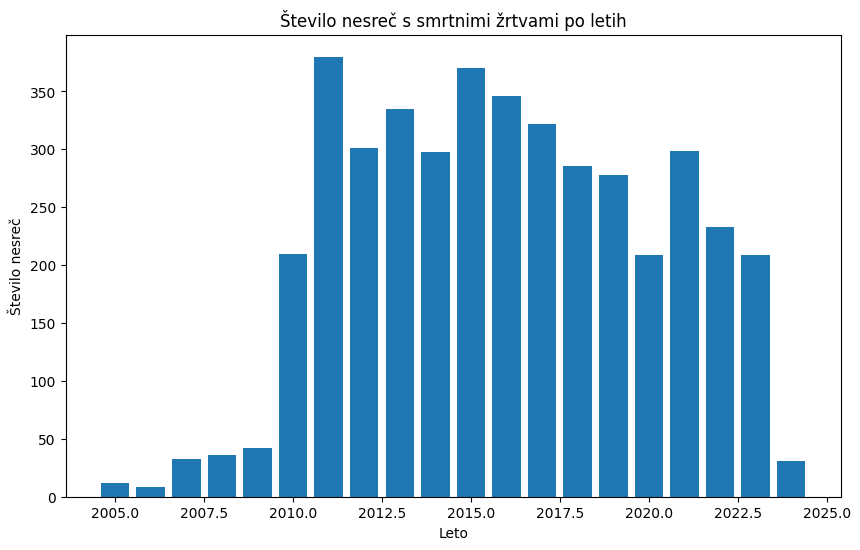

In [13]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(death_accidents_per_year.index, death_accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč s smrtnimi žrtvami po letih')

## Prikaz števila vseh treh kategorij nesreč

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(mild_accidents_per_year.index, mild_accidents_per_year.values, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(mild_accidents_per_year.index, injury_accidents_per_year.values, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(mild_accidents_per_year.index, death_accidents_per_year.values, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.ylabel('Število nesreč')
plt.title('Število nesreč po letih')
plt.legend()

plt.show()

## Prikaz normaliziranih vrednosti za lažjo primerjavo

X_norm = (X - X_min) / (X_max - X_min)

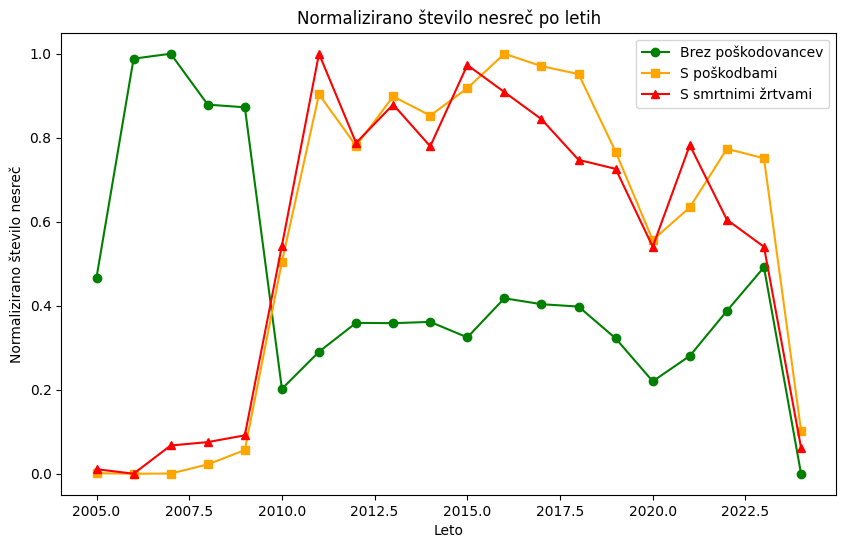

In [15]:
# Normaliziranje
mild_norm = (mild_accidents_per_year.values - np.min(mild_accidents_per_year.values)) / (np.max(mild_accidents_per_year.values) - np.min(mild_accidents_per_year.values))
injury_norm = (injury_accidents_per_year.values - np.min(injury_accidents_per_year.values)) / (np.max(injury_accidents_per_year.values) - np.min(injury_accidents_per_year.values))
death_norm = (death_accidents_per_year.values - np.min(death_accidents_per_year.values)) / (np.max(death_accidents_per_year.values) - np.min(death_accidents_per_year.values))

plt.figure(figsize=(10, 6))

plt.plot(mild_accidents_per_year.index, mild_norm, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(mild_accidents_per_year.index, injury_norm, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(mild_accidents_per_year.index, death_norm, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.xlabel('Leto')
plt.ylabel('Normalizirano število nesreč')
plt.title('Normalizirano število nesreč po letih')
plt.legend()

plt.show()

Opažanja: Nekaj se je moralo spremeniti v beleženju prometnih nesreč leta 2010, ker so številke pred 2010 popolnoma drugačne, kakor potem.